<a href="https://colab.research.google.com/github/yeonju73/Image-Matching-System/blob/main/fine_tuning_cnn_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsummary

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary

import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124


## Prepair Dataset

In [2]:
!git clone https://github.com/hbcbh1999/recaptcha-dataset.git

Cloning into 'recaptcha-dataset'...
remote: Enumerating objects: 11745, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 11745 (delta 0), reused 0 (delta 0), pack-reused 11742 (from 1)
Receiving objects: 100% (11745/11745), 395.63 MiB | 48.32 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (11778/11778), done.


In [3]:
!rm -rf ./recaptcha-dataset/Large/Mountain/
!rm -rf ./recaptcha-dataset/Large/Other/
!rm -rf ./recaptcha-dataset/Large/readme.txt

ImageFolder structure

```
data_dir/Bicycle/xxx.png
data_dir/Bicycle/xxy.png
data_dir/Bicycle/[...]/xxz.png
...
data_dir/Traffic Light/123.png
data_dir/Traffic Light/nsdf3.png
data_dir/Traffic Light/[...]/asd932_.png
```



In [4]:
data_dir = "./recaptcha-dataset/Large"
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

input_size = 224
batch_size = 32

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

print("Initializing Datasets and Dataloaders...")

image_datasets = datasets.ImageFolder(data_dir, data_transforms)  # your dataset
num_data = len(image_datasets)
indices = np.arange(num_data)
np.random.shuffle(indices)

train_size = int(num_data*0.8) # 80 퍼센트는 학습, 20 퍼센트는 검증
train_indices = indices[:train_size]
val_indices = indices[train_size:]
train_set = torch.utils.data.Subset(image_datasets, train_indices)
val_set = torch.utils.data.Subset(image_datasets, val_indices)

print('Number of training data:', len(train_set))
print('Number of validation data:', len(val_set))

dataloaders = {'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
                 'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)}

Initializing Datasets and Dataloaders...
Number of training data: 8233
Number of validation data: 2059


In [5]:
def imshow(imgs, title=None):
    """Display image for Tensor."""
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


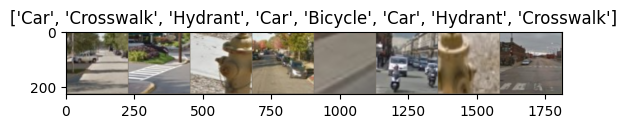

In [6]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


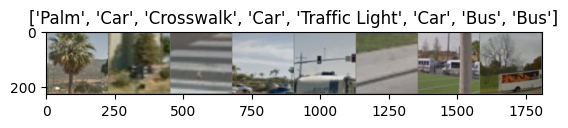

In [7]:
# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

## Build model

### ResNet from scratch

![resnet](https://pytorch.org/assets/images/resnet.png)

In [8]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [10]:
class ResNet_18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers -> 각각 4개씩 선언?
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        self.layer5 = self.__make_layer(512, 1024, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)              # ← Dropout 추가
        self.fc = nn.Linear(1024, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # 16 개 레이어 통과
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        # feature 맵 사이즈를 동일하게 줄여줌
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

In [11]:
model = ResNet_18(image_channels=3, num_classes=10)
summary(model, (3, 224, 224), device='cpu')
# summary(model, (3, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            Block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Resnet from model zoo

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 파라미터를 학습되지 않게

In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224

    elif model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        # Dropout + Linear head 추가
        model_ft.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [14]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

num_classes = 10
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False # 학습을 할 것이기 때문에

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
summary(model_ft, (3, 224, 224), device='cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Train model

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [16]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0015, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [19]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6196 Acc: 0.7995
val Loss: 0.5999 Acc: 0.8174

Epoch 1/24
----------
train Loss: 0.5590 Acc: 0.8153
val Loss: 0.5832 Acc: 0.8198

Epoch 2/24
----------
train Loss: 0.5502 Acc: 0.8179
val Loss: 0.5774 Acc: 0.8232

Epoch 3/24
----------
train Loss: 0.5441 Acc: 0.8212
val Loss: 0.5928 Acc: 0.8111

Epoch 4/24
----------
train Loss: 0.5054 Acc: 0.8355
val Loss: 0.5417 Acc: 0.8324

Epoch 5/24
----------
train Loss: 0.5254 Acc: 0.8293
val Loss: 0.5380 Acc: 0.8256

Epoch 6/24
----------
train Loss: 0.4837 Acc: 0.8406
val Loss: 0.5722 Acc: 0.8193

Epoch 7/24
----------
train Loss: 0.4835 Acc: 0.8402
val Loss: 0.5570 Acc: 0.8334

Epoch 8/24
----------
train Loss: 0.4728 Acc: 0.8479
val Loss: 0.5729 Acc: 0.8232

Epoch 9/24
----------
train Loss: 0.4568 Acc: 0.8485
val Loss: 0.5754 Acc: 0.8242

Epoch 10/24
----------
train Loss: 0.4498 Acc: 0.8515
val Loss: 0.5738 Acc: 0.8198

Epoch 11/24
----------
train Loss: 0.4357 Acc: 0.8568
val Loss: 0.5916 Acc: 0.8169

Ep



```
# 코드로 형식 지정됨
```

## Save the model & features

In [20]:
# 모델의 웨이트만 저장
torch.save(model_ft.state_dict(), 'resnet18.pt')

In [21]:
torch.save(model_ft, 'resnet18_ft.pt')

In [ ]:
model_ft = torch.load('resnet18_ft.pt', weights_only=False)
modules = list(model_ft.children())[:-1]
resnet18_feat = nn.Sequential(*modules)

for p in resnet18_feat.parameters():
    p.requires_grad = False

In [ ]:
# Test
out = resnet18_feat(torch.rand(1, 3, 224, 224).to(device))
print(out.shape)

out = out.view([-1, 512])
print(out.shape)

out = out.detach().cpu().numpy()
print(type(out))

torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
<class 'numpy.ndarray'>


In [ ]:
from tqdm import tqdm

In [ ]:
train_features = []
train_labels = []
val_features = []
val_labels = []

for inputs, labels in tqdm(dataloaders['train']):
  inputs = inputs.to(device)
  h = resnet18_feat(inputs)

  # Eliminate unnecessary dimensions
  h = h.view([-1, 512])

  # Move to 'cpu' & change to 'numpy array'
  h = h.detach().cpu().numpy()

  train_features.append(h)

  # labels
  train_labels.append(labels.detach().cpu().numpy())

for inputs, labels in tqdm(dataloaders['val']):
  inputs = inputs.to(device)
  h = resnet18_feat(inputs)

  # Eliminate unnecessary dimensions
  h = h.view([-1, 512])
  # Move to 'cpu' & change to 'numpy array'
  h = h.detach().cpu().numpy()

  val_features.append(h)

  # labels
  val_labels.append(labels.detach().cpu().numpy())

100%|██████████| 65/65 [00:05<00:00, 12.03it/s]


In [ ]:
train_features = np.concat(train_features, axis=0)
train_labels = np.concat(train_labels, axis=0)
val_features = np.concat(val_features, axis=0)
val_labels = np.concat(val_labels, axis=0)

print(f"Train Features: ({train_features.shape})")
print(f"Train Labels: ({train_labels.shape})")
print(f"Validation Features: ({val_features.shape})")
print(f"Validation Labels: ({val_labels.shape})")

Train Features: ((8233, 512))
Train Labels: ((8233,))
Validation Features: ((2059, 512))
Validation Labels: ((2059,))


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

recaptcha = './recaptcha-dataset/Large/'
labels = ['Bicycle','Bridge','Bus','Car','Chimney',
          'Crosswalk','Hydrant','Motorcycle','Palm','Traffic Light']

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_features, train_labels)

KNeighborsClassifier()

In [ ]:
predict_labels = classifier.predict(val_features)
print(classification_report(val_labels, predict_labels, labels=labels))

               precision    recall  f1-score   support

      Bicycle       0.00      0.00      0.00         0
       Bridge       0.00      0.00      0.00         0
          Bus       0.00      0.00      0.00         0
          Car       0.00      0.00      0.00         0
      Chimney       0.00      0.00      0.00         0
    Crosswalk       0.00      0.00      0.00         0
      Hydrant       0.00      0.00      0.00         0
   Motorcycle       0.00      0.00      0.00         0
         Palm       0.00      0.00      0.00         0
Traffic Light       0.00      0.00      0.00         0

    micro avg       0.00      0.00      0.00         0
    macro avg       0.00      0.00      0.00         0
 weighted avg       0.00      0.00      0.00         0



In [ ]:
predict_labels

array([0, 3, 6, ..., 3, 3, 9])

In [ ]:
neigh_ind = classifier.kneighbors(X=val_features, n_neighbors=10, return_distance=False) # Top-10 results
neigh_labels = np.array(train_labels)[neigh_ind]
print(neigh_labels[:2])

# 숫자를 이름으로 변경
neigh_label_names = [[labels[idx] for idx in topk] for topk in neigh_labels]
print(neigh_label_names[:2])

[[0 0 0 0 0 0 0 0 0 0]
 [3 3 3 3 3 3 3 3 3 3]]
[['Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle'], ['Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car']]


In [22]:
# extract_and_save_features.py

import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import joblib
from tqdm import tqdm

# 1) Feature extractor 정의 (fine-tuned 모델 로드)
def get_feature_extractor(model_path, device='cuda'):
    # 1. 원래 구조대로 모델 생성 (pretrained=False!)
    # If loading the entire model object, we don't need to recreate the model architecture here.
    # Instead, we will load the entire saved model.
    # model = models.resnet18(pretrained=False)
    # # 2. 학습 당시 붙였던 fc 레이어 모양 그대로 복원
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    # 3. 저장해둔 체크포인트 로드 (entire model object)
    # Explicitly set weights_only=False to load the full model object
    model = torch.load(model_path, map_location=device, weights_only=False)

    # 4. fc 바로 전까지 자르고 eval 모드로
    # Make sure the loaded model is on the correct device before accessing children
    model.to(device)
    model.eval() # Set the model to evaluation mode

    modules = list(model.children())[:-1]   # avgpool 까지
    feat_extractor = nn.Sequential(*modules)
    # Move the sequential model to device as well, although the original model is already moved
    feat_extractor.to(device)
    feat_extractor.eval() # Ensure the feature extractor is also in eval mode

    return feat_extractor

# 2) 이미지 전처리 정의
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

def extract_feature(img_path, model, device='cuda'):
    img = Image.open(img_path).convert('RGB')
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = model(x)             # (1, 512, 1, 1)
        feat = feat.view(feat.size(0), -1)  # (1, 512)
    return feat.cpu().numpy().squeeze()   # (512,)


if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 학습 시 클래스 개수와 동일하게 세팅
    # NUM_CLASSES is not needed here as we are loading the entire model
    # NUM_CLASSES   = 10
    MODEL_PATH    = 'resnet18_ft.pt'      # <-- fine-tuned 모델 파일
    DATASET_DIR   = './recaptcha-dataset/Large'
    CLASS_NAMES   = ['Bicycle','Bridge','Bus','Car',
                     'Chimney','Crosswalk','Hydrant',
                     'Motorcycle','Palm','Traffic Light']

    # 1) fine-tuned 모델 불러와서 feature extractor 준비
    # Pass the device to the function
    feat_model = get_feature_extractor(MODEL_PATH, device)

    all_feats = []
    all_labels = []

    # 2) 폴더별 순회하며 feature 추출
    for cls in CLASS_NAMES:
        folder = os.path.join(DATASET_DIR, cls)
        for fname in tqdm(sorted(os.listdir(folder)), desc=f'Extracting {cls}'):
            path = os.path.join(folder, fname)
            # Pass the device to the feature extraction function
            fv = extract_feature(path, feat_model, device)
            all_feats.append(fv)
            all_labels.append(cls)

    # 3) 저장
    feats_array = np.stack(all_feats, axis=0)
    np.save('db_feats.npy', feats_array)
    joblib.dump(all_labels, 'db_labels.pkl')

    print(f'Saved features: db_feats.npy ({feats_array.shape}), db_labels.pkl ({len(all_labels)})')

Extracting Traffic Light: 100%|██████████| 811/811 [00:04<00:00, 178.20it/s]


Saved features: db_feats.npy ((10292, 512)), db_labels.pkl (10292)


In [23]:
# knn_inference.py

import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

# 재사용: extract_and_save_features.py 에서 정의한 함수들을 복붙해 주세요
def get_feature_extractor(device='cuda'):
    model = models.resnet18(pretrained=False)  # pretrained=True 로도 무방
    modules = list(model.children())[:-1]
    feat_extractor = nn.Sequential(*modules)
    feat_extractor.eval()
    feat_extractor.to(device)
    return feat_extractor

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

def extract_feature(img_path, model, device='cuda'):
    img = Image.open(img_path).convert('RGB')
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = model(x)
        feat = feat.view(feat.size(0), -1)
    return feat.cpu().numpy().squeeze()

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    feat_model = get_feature_extractor(device)

    # 1) DB features 불러오기
    db_feats  = np.load('db_feats.npy')        # shape (N,512)
    db_labels = joblib.load('db_labels.pkl')   # list of length N

    # 2) KNN 분류기 학습 (Top-1) / 검색(Top-k)
    knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')  # cosine 거리 사용
    knn.fit(db_feats, db_labels)

    # 3) 챌린지 이미지 폴더 (예: 당일 공개된 100장)
    test_dir = './challenge_images'
    results_top1 = []
    results_top10 = []

    for fn in tqdm(sorted(os.listdir(test_dir)), desc='Inferring'):
        path = os.path.join(test_dir, fn)
        qf = extract_feature(path, feat_model, device)  # (512,)

        # Top-1 예측
        pred1 = knn.predict(qf.reshape(1,-1))[0]
        results_top1.append((fn, pred1))

        # Top-10 검색 (메서드 제공 안될 경우 직접 거리 계산 후 추출 가능)
        dists, idxs = knn.kneighbors(qf.reshape(1,-1), n_neighbors=10, return_distance=True)
        top10 = [ db_labels[i] for i in idxs[0] ]
        results_top10.append((fn, top10))

    # 4) 결과 저장 또는 출력
    with open('c2_t1_a1.csv', 'w') as f1, open('c2_t2_a1.csv', 'w') as f10:
        import csv
        w1 = csv.writer(f1)
        w10 = csv.writer(f10)
        for (fn,p1), (_,p10) in zip(results_top1, results_top10):
            w1.writerow([fn, p1])
            w10.writerow([fn] + p10)

    print("Done. Outputs ▶ c2_t1_a1.csv, c2_t2_a1.csv")


FileNotFoundError: [Errno 2] No such file or directory: './challenge_images'

In [ ]:
import csv

def eval_task1(path):
    total = 0
    correct = 0
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            # row 예시: ['Bicycle/Bicycle (733).png', 'Bicycle']
            total += 1
            actual = row[0]
            pred   = row[1]
            if actual.startswith(pred):
                correct += 1
    acc = correct / total if total else 0
    print(f"Task-1 Top-1 Accuracy: {correct}/{total} = {acc:.4f}")


def eval_task2(path):
    total_rows = 0
    correct_items = 0
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            # row 예시: ['Bicycle/Bicycle (416).png',
            #           'Bicycle','Bus','Car',...,'Bicycle']
            total_rows += 1
            actual = row[0]
            preds   = row[1]
            # 이 행에서 실제 클래스와 일치하는 예측 항목 수
            cnt = sum(1 for p in preds if actual.startswith(p))
            correct_items += cnt
    total_items = total_rows * 10
    precision = correct_items / total_items if total_items else 0
    print(f"Task-2 Top-10 Precision: {correct_items}/{total_items} = {precision:.4f}")


if __name__ == "__main__":
    eval_task1("c2_t1_a1.csv")
    eval_task2("c2_t2_a1.csv")


Task-1 Top-1 Accuracy: 10/100 = 0.1000
Task-2 Top-10 Precision: 30/1000 = 0.0300


In [5]:
# extract_features.py

import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import joblib
from tqdm import tqdm

# 설정
MODEL_PATH  = 'resnet18.pt' # Assuming this is where the state dict is saved
DATA_DIR    = './recaptcha-dataset/Large'
CLASS_NAMES = ['Bicycle','Bridge','Bus','Car','Chimney',
               'Crosswalk','Hydrant','Motorcycle','Palm','Traffic Light']
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Fine-tuned 모델 로드
def load_model(path, device):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(CLASS_NAMES))

    # Load the state dictionary
    state_dict = torch.load(path, map_location=device)

    # Adjust keys if necessary (e.g., from 'fc.1' to 'fc')
    new_state_dict = {}
    for k, v in state_dict.items():
        if 'fc.1.' in k:
            new_key = k.replace('fc.1.', 'fc.')
            new_state_dict[new_key] = v
        else:
            new_state_dict[k] = v

    model.load_state_dict(new_state_dict)
    model.to(device).eval()
    return model

# 2) Feature Extractor 만들기
def make_extractor(model):
    layers = list(model.children())[:-1]  # avgpool 바로 다음이 fc 이므로 그 전까지
    feat_ext = nn.Sequential(*layers).to(DEVICE)
    feat_ext.eval()
    return feat_ext

# 3) 전처리
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

def extract(img_path, extractor):
    img = Image.open(img_path).convert('RGB')
    x = preprocess(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        feat = extractor(x)              # (1,512,1,1)
        feat = feat.view(feat.size(0), -1)  # (1,512)
    return feat.cpu().numpy().squeeze()     # (512,)

# if __name__ == '__main__':
#     model      = load_model(MODEL_PATH, DEVICE)
#     extractor  = make_extractor(model)

#     feats, labels = [], []
#     for cls in CLASS_NAMES:
#         folder = os.path.join(DATA_DIR, cls)
#         if not os.path.exists(folder):
#             print(f"Warning: Folder not found: {folder}. Skipping.")
#             continue
#         for fname in tqdm(sorted(os.listdir(folder)), desc=cls):
#             path = os.path.join(folder, fname)
#             fv = extract(path, extractor)
#             feats.append(fv)
#             labels.append(cls)

#     feats = np.stack(feats, axis=0)    # (N,512)
#     np.save('db_feats_recaptcha.npy', feats)
#     joblib.dump(labels, 'db_labels_recaptcha.pkl')
#     print(f'Saved db_feats_recaptcha.npy ({feats.shape}), db_labels_recaptcha.pkl ({len(labels)})')

In [8]:
# knn_inference.py

import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import joblib
from tqdm import tqdm
import csv


def main():
  # 1) DB features & labels 로드
  db_feats  = np.load('db_feats_recaptcha.npy')        # (N,512)
  db_labels = joblib.load('db_labels_recaptcha.pkl')   # 길이 N

  # 2) KNN 학습
  knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
  knn.fit(db_feats, db_labels)

  # 3) Query 이미지들 feature 추출 (extract_features.py 의 extract 함수 사용)

  # 동일 extractor 준비
  model     = load_model('resnet18.pt', device='cpu')
  extractor = make_extractor(model)

  # 4) CSV 파일 오픈
  out1 = open('c2_t1_a1.csv', 'w', newline='', encoding='utf-8')
  out2 = open('c2_t2_a1.csv', 'w', newline='', encoding='utf-8')
  writer1 = csv.writer(out1)
  writer2 = csv.writer(out2)

  # 5) query 폴der의 이미지 리스트
  query_dir = './query'
  image_files = sorted([
      f for f in os.listdir(query_dir)
      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
  ])

  # 6) 예측 & 저장
  for fname in image_files:
    img_path = os.path.join(query_dir, fname)
    feat = extract(img_path, extractor)               # (D,)
    # Top-1
    top1 = knn.predict(feat.reshape(1, -1))[0]
    writer1.writerow([fname, top1])

    # Top-10 Retrieval
    dists, idxs = knn.kneighbors(feat.reshape(1, -1), n_neighbors=10)
    top10 = [db_labels[i] for i in idxs[0]]
    writer2.writerow([fname] + top10)

  # 7) 파일 닫기
  out1.close()
  out2.close()

if __name__ == '__main__':
    main()

query001.png → Top-1: Crosswalk | Top-10: ['Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk']
query002.png → Top-1: Car | Top-10: ['Bicycle', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Hydrant', 'Hydrant']
query003.png → Top-1: Bicycle | Top-10: ['Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle']
query004.png → Top-1: Chimney | Top-10: ['Chimney', 'Chimney', 'Chimney', 'Chimney', 'Chimney', 'Chimney', 'Chimney', 'Chimney', 'Chimney', 'Chimney']
query005.png → Top-1: Traffic Light | Top-10: ['Traffic Light', 'Traffic Light', 'Traffic Light', 'Traffic Light', 'Bus', 'Traffic Light', 'Bus', 'Traffic Light', 'Bus', 'Car']
query006.png → Top-1: Crosswalk | Top-10: ['Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk', 'Crosswalk']
query007.png → Top-1: Bus | Top-10: ['Bus', 'Bus', 'Car'